There are two ways of getting the presentation of the words. One is using the CBOW and Skip-gram. In the CBOW method, when we are given a set of context words we have to predict the word corresponding to it while in Skip Gram, given the word we have to predict the words around it. Let's try of Skip gram model!!!!.

In [5]:
import numpy as np
text = "This is my new text for trying out the skip gram model".split()
context =2
skip_gram=[]
for i in range(context,len(text)-context):
    context_list=[]
    for j in range(i-context,i+context+1):
        if j!=i:
            context_list.append(text[j])
    skip_gram.append((text[i],context_list))

In [6]:
skip_gram

[('my', ['This', 'is', 'new', 'text']),
 ('new', ['is', 'my', 'text', 'for']),
 ('text', ['my', 'new', 'for', 'trying']),
 ('for', ['new', 'text', 'trying', 'out']),
 ('trying', ['text', 'for', 'out', 'the']),
 ('out', ['for', 'trying', 'the', 'skip']),
 ('the', ['trying', 'out', 'skip', 'gram']),
 ('skip', ['out', 'the', 'gram', 'model'])]

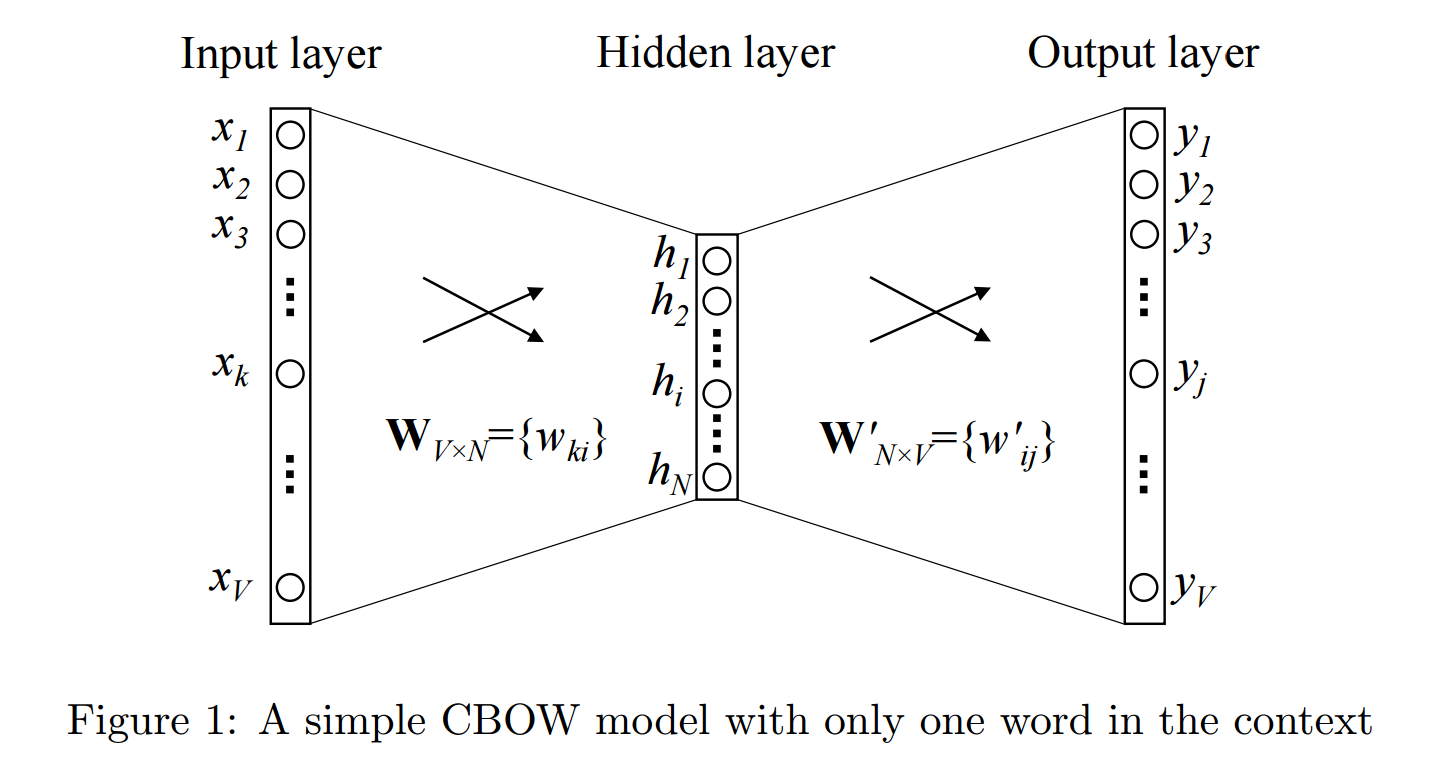
Source : https://lilianweng.github.io/posts/2017-10-15-word-embedding/
This is Word2Vec model where we first take the one-hot encoding of input word to W_embed and then to W_out to get the output probabilities 

In [7]:
!pip install -qU gensim

In [8]:
from gensim.models.word2vec import Word2Vec

In [14]:
text

['This',
 'is',
 'my',
 'new',
 'text',
 'for',
 'trying',
 'out',
 'the',
 'skip',
 'gram',
 'model']

In [10]:
model = Word2Vec(text,sg=1, vector_size=10, window=2, min_count=0, workers=4)
model.wv.save_word2vec_format("got_word2vec.txt", binary=False)

In [11]:
print(model.wv.vectors.shape)

(21, 10)


We can see that this is the same as W_embed. The sg=1 ensures that the skip-gram is chosen, window indicates the context size. hs=1 can be used to have Hierarchical softmax.

In [12]:
model.train([text], total_examples=model.corpus_count, epochs=10)

(0, 120)

In [13]:
print(model.wv[0])

[-0.00536218  0.00238271  0.05105656  0.09011675 -0.09304549 -0.07116832
  0.06461874  0.08972701 -0.05017912 -0.03760906]


Now we can use DeepWalks to generate node representation. It can be thought as like this, the random walk can produce a sequence of nodes that can act like a sentence. If two nodes appear together many times in the line, they are close. Now let us implement it.

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import random

In [16]:
random.seed(42) # for reproducability

In [19]:
G = nx.erdos_renyi_graph(20, 0.5, seed=42, directed=False)

This is a special type of graph generator. There are more available in network library.

In [21]:
def random_walk(start,length):
    walk =[start]
    for i in range(length):
        next_nodes = [node for node in G.neighbors(start)] 
        next_node = np.random.choice(next_nodes,42)[1]
        walk.append(next_node)
        start = next_node
    return walk

In [ ]:
print(